In [1]:
import os
import monai
import torch
import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import UNet, AttentionUnet
from monai.data import DataLoader, CacheDataset, ImageDataset, Dataset, image_reader
from monai.data.utils import pad_list_data_collate
from monai.transforms import Compose, ScaleIntensity, ToTensor,LoadImaged, ScaleIntensityd, ToTensord,EnsureChannelFirstd
import SimpleITK as sitk
from monai.data.image_reader import ITKReader
from monai.losses import DiceLoss, DiceCELoss, DiceFocalLoss, FocalLoss, GeneralizedDiceLoss

from monai.metrics import MSEMetric

import dataset
# import dataset_low_resolution

from dataset import PelvisDataset
import dataset_old
import numpy as np
import sklearn
from monai.metrics import compute_hausdorff_distance
from UNETR import UNETR
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import time

2024-01-11 12:20:12.567016: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 12:20:13.312466: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# DATASET

Train dataset and dataloader

In [2]:
# train
root_dir ="/home/paulagmtz/TFM_PAULA_24/DATA_TFM/train_files"
input_dim = (194,148,105)
n_labels= 6
train_dataset = PelvisDataset(root_dir,input_dim, n_labels, transform=None)

train_dataloader = DataLoader(train_dataset, collate_fn=pad_list_data_collate,batch_size =2)

In [3]:
# root_dir ="/home/paulagmtz/TFM_PAULA_24/DATA_TFM/train_files"
# # input_dim = (176,128,240)
# input_dim = (194,148,105)

# n_labels= 2

# train_dataset = dataset_low_resolution.PelvisDataset(root_dir,input_dim, n_labels,transform=None)

# train_dataloader = DataLoader(train_dataset, batch_size =1)

validation dataloader

In [3]:
root_dir ="/home/paulagmtz/TFM_PAULA_24/DATA_TFM/val_files"
input_dim =(194,148,105)
n_labels= 6
val_dataset = PelvisDataset(root_dir,input_dim, n_labels, transform=None)

val_dataloader = DataLoader(val_dataset, batch_size =1)

In [5]:
# root_dir ="/home/paulagmtz/TFM_PAULA_24/DATA_TFM/val_files"
# input_dim =(194,148,105)
# n_labels= 2

# val_dataset = dataset_low_resolution.PelvisDataset(root_dir,input_dim, n_labels,transform=None)

# val_dataloader = DataLoader(val_dataset, batch_size =2)

test dataloader

In [4]:
root_dir ="/home/paulagmtz/TFM_PAULA_24/DATA_TFM/test_files"
input_dim =(194,148,105)
n_labels= 6
test_dataset = PelvisDataset(root_dir,input_dim, n_labels, transform=None)

test_dataloader = DataLoader(test_dataset, batch_size =1)

# PLOT FUNCTIONS

In [5]:
def plot_loss_evolution(loss_evolution):
    plt.figure(figsize=(10,5))
    plt.plot(loss_evolution)
    plt.title('Loss Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

In [6]:
def plot_results(inputs, targets, outputs):
    depth_slice = inputs[:, :, :, :, :]
    depth_slice_target = targets[:, :, :, :, :]
    depth_slice_outputs = outputs[:, :, :, :, :]

    def plot_image(i):
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))

        image_array = depth_slice[0, :, i, :, :].cpu().detach().numpy()
        image_array_target = depth_slice_target[0, :, i, :, :].cpu().detach().numpy()
        image_array_outputs = depth_slice_outputs[0, :, i, :, :].cpu().detach().numpy()

        axes[0].imshow(image_array[0, :, :], cmap="gray")
        axes[0].set_title("inputs")
        axes[0].axis('off')

        axes[1].imshow(image_array_target[0, :, :], cmap="gray")
        axes[1].set_title("target")
        axes[1].axis('off')

        axes[2].imshow(image_array_outputs[0, :, :], cmap="gray")
        axes[2].set_title("output")
        axes[2].axis('off')

        plt.show()

    widgets.interact(plot_image, i=widgets.IntSlider(min=0, max=depth_slice.shape[2]-1, step=1, value=22))


In [7]:
def plot_targets(targets):
            depth_slice = targets[:, :, :, :]

            def plot_images(slice_index):
                fig, axes = plt.subplots(1, 7, figsize=(20, 10))

                for i in range(7):
                    image_array = depth_slice[i, slice_index, :, :].cpu().detach().numpy()
                    axes[i].imshow(image_array, cmap="gray")
                    axes[i].set_title("Channel {}".format(i))
                    axes[i].axis('off')

                plt.show()

            interact(plot_images, slice_index=widgets.IntSlider(min=0, max=depth_slice.shape[1] - 1, step=1, value=22))


In [8]:
# Función para mostrar imágenes de inputs, targets y outputs
def plot_multilabel_results(inputs, targets, outputs):
    depth_slice = inputs[:, :, :, :, :]
    depth_slice_target = targets[:, :, :, :, :]
    depth_slice_outputs = outputs[:, :, :, :, :]

    def plot_image(i):
        
        fig, axes = plt.subplots(7, 3, figsize=(20, 15))
        
        for c in range(7):
            image_array = depth_slice[0, :, i, :, :].cpu().detach().numpy()
            image_array_target = depth_slice_target[0,c, i, :, :].cpu().detach().numpy()
            image_array_outputs = depth_slice_outputs[0, c, i, :, :].cpu().detach().numpy()

            axes[c,0].imshow(image_array[0, :, :], cmap="gray")
            axes[c,0].set_title("inputs")
            axes[c,0].axis('off')

            axes[c,1].imshow(image_array_target, cmap="gray")
            axes[c,1].set_title("target")
            axes[c,1].axis('off')

            axes[c,2].imshow(image_array_outputs, cmap="gray")
            axes[c,2].set_title("output")
            axes[c,2].axis('off')

        plt.show()

    widgets.interact(plot_image, i=widgets.IntSlider(min=0, max=depth_slice.shape[2]-1, step=1, value=22))


# UNET


In [26]:
import torch
torch.cuda.empty_cache()

In [27]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3 ,
    in_channels=1,
    out_channels=7,
    channels=(64,128,256,512), 
    strides=(2,2,2),
    # num_res_units=2,
    # norm=Norm.BATCH,    
).to(device)


In [12]:
import torch
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(f"Estás conectado a una GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No estás conectado a una GPU.")

Estás conectado a una GPU: NVIDIA GeForce RTX 3090


defino dice y cross entropy loss function

In [28]:
# loss_function = nn.BCELoss()
#
dice_loss_function = DiceLoss(sigmoid=True, squared_pred=True) 
diceCE_loss_function = DiceCELoss(sigmoid=True)
dicefocall_loss_function = DiceFocalLoss(sigmoid=True)
generalizedDice_loss_function = GeneralizedDiceLoss(sigmoid=True)


optimizer = optim.Adam(model.parameters(), lr=1e-3)


Train model

In [15]:
num_epochs = 200
loss_evolution_train = []
count = 0
inicio = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch in train_dataloader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # print(targets.size)
        
        out =  nn.functional.sigmoid(outputs)
        # out = nn.functional.softmax(outputs, dim = 0)
        
        loss = diceCE_loss_function(outputs, targets)
        loss.backward()
        
        optimizer.step()
        # plot_multilabel_results(inputs, targets, outputs)
        
        # plot_results(inputs,targets,outputs)
    loss_evolution_train.append(loss)
    if count == 25:
        plot_multilabel_results(inputs, targets, outputs)
        count = 0
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {loss.item()}")
        
    count = count + 1
    

print("Training complete.")
plot_multilabel_results(inputs, targets, outputs)
fin = time.time()

# Calcula la diferencia
tiempo_total = fin - inicio

print(f"Tiempo de ejecución: {tiempo_total} segundos")

Epoch [1/200] - Loss: 1.0001572370529175
Epoch [2/200] - Loss: 1.0000648498535156
Epoch [3/200] - Loss: 0.9999899864196777
Epoch [4/200] - Loss: 0.9999440908432007
Epoch [5/200] - Loss: 0.999886691570282
Epoch [6/200] - Loss: 0.9997041821479797
Epoch [7/200] - Loss: 0.998566210269928
Epoch [8/200] - Loss: 0.9973514676094055
Epoch [9/200] - Loss: 0.9689012169837952
Epoch [10/200] - Loss: 0.9603275060653687
Epoch [11/200] - Loss: 0.9265539050102234
Epoch [12/200] - Loss: 0.8414891958236694
Epoch [13/200] - Loss: 0.8260199427604675
Epoch [14/200] - Loss: 0.7746447920799255
Epoch [15/200] - Loss: 0.7501657605171204
Epoch [16/200] - Loss: 0.7113004922866821


KeyboardInterrupt: 

In [ ]:
# num_epochs = 200
# loss_evolution = []

# for epoch in range(num_epochs):
    
#     model.train()
#     # for batch in train_dataloader:
#     for batch in next(iter(train_dataloader)):
#         inputs, targets = batch[0].to(device), batch[1].to(device)
        
#             # Imprime las formas de las salidas intermedias
#         for i, layer in enumerate(model.model.children()):  # `model.model` accede a la U-Net interna en MONAI
#             print(f"Layer {i + 1}:", layer)
#             inputs = layer(inputs)
#             if isinstance(layer, monai.networks.layers.simplelayers.SkipConnection):
#                 x, y = inputs  # Desempaqueta los tensores x e y
#                 print(f"Layer {i + 1} - x shape:", x.shape)
#                 print(f"Layer {i + 1} - y shape:", y.shape)
#             else:
#                 print(f"Layer {i + 1} output shape:", inputs.shape)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         # out = nn.functional.softmax(outputs, dim = 0)
        
#         loss = loss_function(outputs, targets)
#         loss.backward()
        
#         optimizer.step()
        
#         plot_results(inputs,targets,outputs)
#     loss_evolution.append(loss)
#     plot_results(inputs,targets,outputs)
#     print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {loss.item()}")

# print("Training complete.")


Layer 1: Convolution(
  (conv): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (adn): ADN(
    (N): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (D): Dropout(p=0.0, inplace=False)
    (A): PReLU(num_parameters=1)
  )
)
Layer 1 output shape: torch.Size([64, 56, 80, 104])
Layer 2: SkipConnection(
  (submodule): Sequential(
    (0): Convolution(
      (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(256, eps=1e-05, momentum=0.1, affine=False, track_

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 256 but got size 512 for tensor number 1 in the list.

Loss evolution

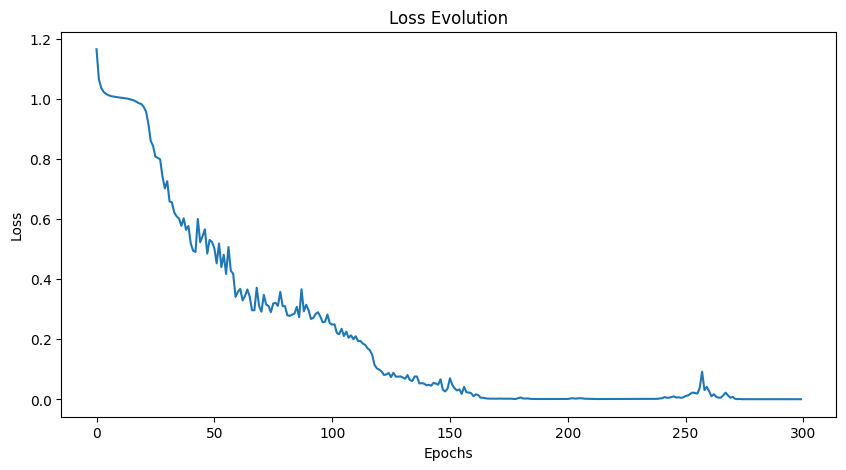

In [ ]:
    
loss_evolution_cpu = [tensor.cpu() for tensor in loss_evolution_train]  # Mover cada tensor a la CPU
loss_evolution_numpy = [tensor.detach().numpy() for tensor in loss_evolution_cpu]  # Convertir cada tensor a un array de NumPy

plot_loss_evolution(loss_evolution_numpy)

Save model

In [ ]:
# Save the model's state_dict to a file
# 'model.pth'
torch.save(model.state_dict(), "/home/paulagmtz/TFM_PAULA_24/DATA_TFM/models_result/UNET_model_SIGMA2_200_sp_dicefocalllosss.pth")


# Load model

In [9]:
# from monai.model import Unet
# # Create an instance of your model (ensure that it has the same architecture)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=3 ,
    in_channels=1,
    out_channels=7,
    channels=(64,128,256,512), 
    strides=(2,2,2),
    # num_res_units=2,
    # norm=Norm.BATCH,    
).to(device)
# Load the saved model parameters
model.load_state_dict(torch.load("/home/paulagmtz/TFM_PAULA_24/DATA_TFM/models_result/UNET_TRUE_MULTILABEL_1_7_model_200.pth"))

# Set the model to evaluation mode
model.eval()


UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): 

# UNETR


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNETR(in_channels=1, out_channels=1, img_size=(167, 120, 232), feature_size=32, norm_name='batch')
model.to(device)

UNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Conv3d(1, 768, kernel_size=(16, 16, 16), stride=(16, 16, 16))
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (blocks): ModuleList(
      (0-11): 12 x TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (fn): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (input_rearrange): Rearrange('b h (qkv l d) -> qkv b l h d', qkv=3, l=12)
          (out_rearrange): Rearrange('b h l d -> b l (h d)')
          (drop_out

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model = UNETR(in_channels=1, out_channels=1, img_size=(112, 160, 208), feature_size=32, norm_name='batch')
# model.to(device)

UNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Conv3d(1, 768, kernel_size=(16, 16, 16), stride=(16, 16, 16))
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (blocks): ModuleList(
      (0-11): 12 x TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (fn): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (input_rearrange): Rearrange('b h (qkv l d) -> qkv b l h d', qkv=3, l=12)
          (out_rearrange): Rearrange('b h l d -> b l (h d)')
          (drop_out

In [ ]:
# loss_function = nn.BCELoss()
loss_function = DiceLoss(sigmoid=True, squared_pred=True)

optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
# Función para mostrar imágenes de inputs, targets y outputs
def plot_results(inputs, targets, outputs):
    depth_slice = inputs[:, :, :, :, :]
    depth_slice_target = targets[:, :, :, :, :]
    depth_slice_outputs = outputs[:, :, :, :, :]

    def plot_image(i):
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))

        image_array = depth_slice[0, :, i, :, :].cpu().detach().numpy()
        image_array_target = depth_slice_target[0, :, i, :, :].cpu().detach().numpy()
        image_array_outputs = depth_slice_outputs[0, :, i, :, :].cpu().detach().numpy()

        axes[0].imshow(image_array[0, :, :], cmap="gray")
        axes[0].set_title("inputs")
        axes[0].axis('off')

        axes[1].imshow(image_array_target[0, :, :], cmap="gray")
        axes[1].set_title("target")
        axes[1].axis('off')

        axes[2].imshow(image_array_outputs[0, :, :], cmap="gray")
        axes[2].set_title("output")
        axes[2].axis('off')

        plt.show()

    widgets.interact(plot_image, i=widgets.IntSlider(min=0, max=depth_slice.shape[2]-1, step=1, value=22))


In [ ]:
num_epochs = 100
loss_evolution = []

for epoch in range(num_epochs):
    
    model.train()
    for batch in train_dataloader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        # out = nn.functional.softmax(outputs, dim = 0)
        
        loss = loss_function(outputs, targets)
        loss.backward()
        
        optimizer.step()
        
        # plot_results(inputs,targets,outputs)
    loss_evolution.append(loss)
    plot_results(inputs,targets,outputs)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {loss.item()}")

print("Training complete.")


final image tensor,  torch.Size([1, 176, 120, 232])
final label tensor,  torch.Size([1, 176, 120, 232])
final image tensor,  torch.Size([1, 176, 120, 232])
final label tensor,  torch.Size([1, 176, 120, 232])


RuntimeError: The size of tensor a (1078) must match the size of tensor b (980) at non-singleton dimension 1

# ATTENTION UNET

In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = AttentionUnet(
    spatial_dims=3 ,
    in_channels=1,
    out_channels=1,
    channels=(64,128), 
    strides=(2,2),
    # num_res_units=2,
    # norm=Norm.BATCH,    
).to(device)

In [ ]:
# loss_function = nn.BCELoss()
#
dice_loss_function = DiceLoss(sigmoid=True, squared_pred=True) 
diceCE_loss_function = DiceCELoss(sigmoid=True)
dicefocall_loss_function = DiceFocalLoss(sigmoid=True)
generalizedDice_loss_function = GeneralizedDiceLoss(sigmoid=True)


optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
num_epochs = 300
loss_evolution_train = []
count = 0
inicio = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch in train_dataloader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        out =  nn.functional.sigmoid(outputs)
        # out = nn.functional.softmax(outputs, dim = 0)
        
        loss = dicefocall_loss_function(outputs, targets)
        loss.backward()
        
        optimizer.step()
        
        # plot_results(inputs,targets,outputs)
    loss_evolution_train.append(loss)
    if count == 50:
        plot_results(inputs,targets,out)
        count = 0
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {loss.item()}")
        
    count = count + 1
    

print("Training complete.")
plot_results(inputs,targets,out)
fin = time.time()

# Calcula la diferencia
tiempo_total = fin - inicio

print(f"Tiempo de ejecución: {tiempo_total} segundos")

Epoch [1/300] - Loss: 1.0370497703552246
Epoch [2/300] - Loss: 1.0190327167510986
Epoch [3/300] - Loss: 1.0103436708450317
Epoch [4/300] - Loss: 1.0064424276351929
Epoch [5/300] - Loss: 1.0045874118804932
Epoch [6/300] - Loss: 1.0030314922332764
Epoch [7/300] - Loss: 1.002220869064331
Epoch [8/300] - Loss: 1.0014246702194214
Epoch [9/300] - Loss: 1.0010550022125244
Epoch [10/300] - Loss: 1.000854730606079
Epoch [11/300] - Loss: 1.0004760026931763
Epoch [12/300] - Loss: 1.0011030435562134
Epoch [13/300] - Loss: 1.0003750324249268
Epoch [14/300] - Loss: 0.9999452233314514
Epoch [15/300] - Loss: 0.9998762607574463
Epoch [16/300] - Loss: 0.9998970031738281
Epoch [17/300] - Loss: 0.9992780685424805
Epoch [18/300] - Loss: 0.9995172619819641
Epoch [19/300] - Loss: 0.9996737241744995
Epoch [20/300] - Loss: 0.9989442229270935
Epoch [21/300] - Loss: 0.999040961265564
Epoch [22/300] - Loss: 0.9985209107398987
Epoch [23/300] - Loss: 0.9970117211341858
Epoch [24/300] - Loss: 0.9970127940177917
Epoc

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

Epoch [51/300] - Loss: 0.6865363121032715
Epoch [52/300] - Loss: 0.6619452834129333
Epoch [53/300] - Loss: 0.6869466304779053
Epoch [54/300] - Loss: 0.6845109462738037
Epoch [55/300] - Loss: 0.6699029803276062
Epoch [56/300] - Loss: 0.6799244284629822
Epoch [57/300] - Loss: 0.6984846591949463
Epoch [58/300] - Loss: 0.6589810848236084
Epoch [59/300] - Loss: 0.7059495449066162
Epoch [60/300] - Loss: 0.7293511033058167
Epoch [61/300] - Loss: 0.6732078194618225
Epoch [62/300] - Loss: 0.6702166795730591
Epoch [63/300] - Loss: 0.6820042729377747
Epoch [64/300] - Loss: 0.6566787958145142
Epoch [65/300] - Loss: 0.6848150491714478
Epoch [66/300] - Loss: 0.6806250214576721
Epoch [67/300] - Loss: 0.6842666268348694
Epoch [68/300] - Loss: 0.6674454808235168
Epoch [69/300] - Loss: 0.6668543815612793
Epoch [70/300] - Loss: 0.6398455500602722
Epoch [71/300] - Loss: 0.6242138743400574
Epoch [72/300] - Loss: 0.6088285446166992
Epoch [73/300] - Loss: 0.6284343004226685
Epoch [74/300] - Loss: 0.665214955

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

Epoch [101/300] - Loss: 0.596976101398468
Epoch [102/300] - Loss: 0.5957566499710083
Epoch [103/300] - Loss: 0.6073439121246338
Epoch [104/300] - Loss: 0.5716307163238525
Epoch [105/300] - Loss: 0.6586340665817261
Epoch [106/300] - Loss: 0.6559546589851379
Epoch [107/300] - Loss: 0.6182240843772888
Epoch [108/300] - Loss: 0.590688169002533
Epoch [109/300] - Loss: 0.5870043635368347
Epoch [110/300] - Loss: 0.6433347463607788
Epoch [111/300] - Loss: 0.6218457818031311
Epoch [112/300] - Loss: 0.5854732394218445
Epoch [113/300] - Loss: 0.5857495069503784
Epoch [114/300] - Loss: 0.5794201493263245
Epoch [115/300] - Loss: 0.570260763168335
Epoch [116/300] - Loss: 0.5714200735092163
Epoch [117/300] - Loss: 0.5771124362945557
Epoch [118/300] - Loss: 0.5875000953674316
Epoch [119/300] - Loss: 0.5716611742973328
Epoch [120/300] - Loss: 0.5632161498069763
Epoch [121/300] - Loss: 0.5958458185195923
Epoch [122/300] - Loss: 0.594095766544342
Epoch [123/300] - Loss: 0.5699816346168518
Epoch [124/300]

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

Epoch [151/300] - Loss: 0.5489023327827454
Epoch [152/300] - Loss: 0.5714524388313293
Epoch [153/300] - Loss: 0.5567401647567749
Epoch [154/300] - Loss: 0.5543755292892456
Epoch [155/300] - Loss: 0.5533828735351562
Epoch [156/300] - Loss: 0.5486562848091125
Epoch [157/300] - Loss: 0.5729953050613403
Epoch [158/300] - Loss: 0.5360103249549866
Epoch [159/300] - Loss: 0.5530160069465637
Epoch [160/300] - Loss: 0.5579423904418945
Epoch [161/300] - Loss: 0.5370094180107117
Epoch [162/300] - Loss: 0.533220112323761
Epoch [163/300] - Loss: 0.5286481380462646
Epoch [164/300] - Loss: 0.534725546836853
Epoch [165/300] - Loss: 0.5496686100959778
Epoch [166/300] - Loss: 0.5342333316802979
Epoch [167/300] - Loss: 0.5304110646247864
Epoch [168/300] - Loss: 0.5254130363464355
Epoch [169/300] - Loss: 0.5337439179420471
Epoch [170/300] - Loss: 0.530745804309845
Epoch [171/300] - Loss: 0.5276038646697998
Epoch [172/300] - Loss: 0.529546856880188
Epoch [173/300] - Loss: 0.5442388653755188
Epoch [174/300]

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

Epoch [201/300] - Loss: 0.5200189352035522
Epoch [202/300] - Loss: 0.5202221870422363
Epoch [203/300] - Loss: 0.5256364941596985
Epoch [204/300] - Loss: 0.5272899866104126
Epoch [205/300] - Loss: 0.5213849544525146
Epoch [206/300] - Loss: 0.5225824117660522
Epoch [207/300] - Loss: 0.5298523902893066
Epoch [208/300] - Loss: 0.5253622531890869
Epoch [209/300] - Loss: 0.5284174680709839
Epoch [210/300] - Loss: 0.5235273241996765
Epoch [211/300] - Loss: 0.5180475115776062
Epoch [212/300] - Loss: 0.5279878973960876
Epoch [213/300] - Loss: 0.5281451344490051
Epoch [214/300] - Loss: 0.5217032432556152
Epoch [215/300] - Loss: 0.5167317390441895
Epoch [216/300] - Loss: 0.5172731876373291
Epoch [217/300] - Loss: 0.5273132920265198
Epoch [218/300] - Loss: 0.5202333331108093
Epoch [219/300] - Loss: 0.5195819735527039
Epoch [220/300] - Loss: 0.5992222428321838
Epoch [221/300] - Loss: 0.5195732712745667
Epoch [222/300] - Loss: 0.5279218554496765
Epoch [223/300] - Loss: 0.5309750437736511
Epoch [224/

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

Epoch [251/300] - Loss: 0.5236950516700745
Epoch [252/300] - Loss: 0.5055378675460815
Epoch [253/300] - Loss: 0.42619454860687256
Epoch [254/300] - Loss: 0.4600968360900879
Epoch [255/300] - Loss: 0.4122934937477112
Epoch [256/300] - Loss: 0.36706116795539856
Epoch [257/300] - Loss: 0.4164271950721741
Epoch [258/300] - Loss: 0.35074108839035034
Epoch [259/300] - Loss: 0.3424909710884094
Epoch [260/300] - Loss: 0.37129855155944824
Epoch [261/300] - Loss: 0.3442804515361786
Epoch [262/300] - Loss: 0.3476700186729431
Epoch [263/300] - Loss: 0.32363831996917725
Epoch [264/300] - Loss: 0.35175442695617676
Epoch [265/300] - Loss: 0.3383238911628723
Epoch [266/300] - Loss: 0.36266028881073
Epoch [267/300] - Loss: 0.3395548462867737
Epoch [268/300] - Loss: 0.3371674120426178
Epoch [269/300] - Loss: 0.29415038228034973
Epoch [270/300] - Loss: 0.30544155836105347
Epoch [271/300] - Loss: 0.3182007968425751
Epoch [272/300] - Loss: 0.3269559144973755
Epoch [273/300] - Loss: 0.2873983085155487
Epoch

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

Tiempo de ejecución: 7538.9016189575195 segundos


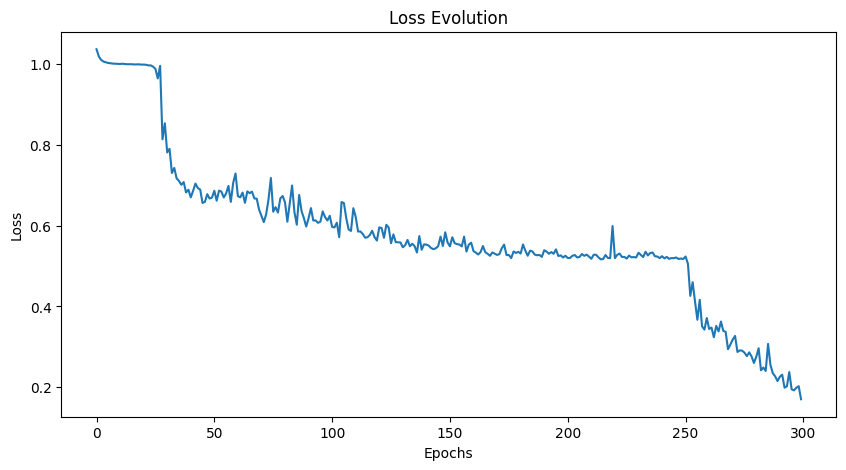

In [ ]:
    
loss_evolution_cpu = [tensor.cpu() for tensor in loss_evolution_train]  # Mover cada tensor a la CPU
loss_evolution_numpy = [tensor.detach().numpy() for tensor in loss_evolution_cpu]  # Convertir cada tensor a un array de NumPy

plot_loss_evolution(loss_evolution_numpy)

In [ ]:
# Save the model's state_dict to a file
# 'model.pth'
torch.save(model.state_dict(), "/home/paulagmtz/TFM_PAULA_24/DATA_TFM/models_result/ATTENTION_UNET_model_SIGMA2_300_sp_dicefocall_loss_low_resolution_1.pth")


In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = AttentionUnet(
    spatial_dims=3 ,
    in_channels=1,
    out_channels=1,
    channels=(64,128), 
    strides=(2,2),
    # num_res_units=2,
    # norm=Norm.BATCH,    
).to(device)

In [ ]:
num_epochs = 300
loss_evolution_train = []
count = 0
inicio = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch in train_dataloader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        out =  nn.functional.sigmoid(outputs)
        # out = nn.functional.softmax(outputs, dim = 0)
        
        loss = diceCE_loss_function(outputs, targets)
        loss.backward()
        
        optimizer.step()
        
        # plot_results(inputs,targets,outputs)
    loss_evolution_train.append(loss)
    if count == 50:
        plot_results(inputs,targets,out)
        count = 0
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {loss.item()}")
        
    count = count + 1
    

print("Training complete.")
plot_results(inputs,targets,out)
fin = time.time()

# Calcula la diferencia
tiempo_total = fin - inicio

print(f"Tiempo de ejecución: {tiempo_total} segundos")

Epoch [1/300] - Loss: 1.7052018642425537
Epoch [2/300] - Loss: 1.7052019834518433
Epoch [3/300] - Loss: 1.7052018642425537
Epoch [4/300] - Loss: 1.7052018642425537
Epoch [5/300] - Loss: 1.7052018642425537
Epoch [6/300] - Loss: 1.7052018642425537
Epoch [7/300] - Loss: 1.7052018642425537
Epoch [8/300] - Loss: 1.7052018642425537
Epoch [9/300] - Loss: 1.7052018642425537
Epoch [10/300] - Loss: 1.7052018642425537
Epoch [11/300] - Loss: 1.7052018642425537
Epoch [12/300] - Loss: 1.7052018642425537
Epoch [13/300] - Loss: 1.7052018642425537
Epoch [14/300] - Loss: 1.7052018642425537
Epoch [15/300] - Loss: 1.7052018642425537
Epoch [16/300] - Loss: 1.7052018642425537
Epoch [17/300] - Loss: 1.7052018642425537
Epoch [18/300] - Loss: 1.7052019834518433
Epoch [19/300] - Loss: 1.7052018642425537
Epoch [20/300] - Loss: 1.7052018642425537
Epoch [21/300] - Loss: 1.7052018642425537
Epoch [22/300] - Loss: 1.7052018642425537
Epoch [23/300] - Loss: 1.7052018642425537
Epoch [24/300] - Loss: 1.7052018642425537
E

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

Epoch [51/300] - Loss: 1.7052018642425537
Epoch [52/300] - Loss: 1.7052018642425537
Epoch [53/300] - Loss: 1.7052018642425537
Epoch [54/300] - Loss: 1.7052018642425537
Epoch [55/300] - Loss: 1.7052018642425537
Epoch [56/300] - Loss: 1.7052018642425537
Epoch [57/300] - Loss: 1.7052018642425537
Epoch [58/300] - Loss: 1.7052018642425537
Epoch [59/300] - Loss: 1.7052018642425537
Epoch [60/300] - Loss: 1.7052018642425537
Epoch [61/300] - Loss: 1.7052018642425537
Epoch [62/300] - Loss: 1.7052018642425537
Epoch [63/300] - Loss: 1.7052019834518433
Epoch [64/300] - Loss: 1.7052018642425537
Epoch [65/300] - Loss: 1.7052018642425537
Epoch [66/300] - Loss: 1.7052018642425537
Epoch [67/300] - Loss: 1.7052018642425537
Epoch [68/300] - Loss: 1.7052018642425537
Epoch [69/300] - Loss: 1.7052018642425537
Epoch [70/300] - Loss: 1.7052018642425537
Epoch [71/300] - Loss: 1.7052018642425537
Epoch [72/300] - Loss: 1.7052018642425537
Epoch [73/300] - Loss: 1.7052018642425537
Epoch [74/300] - Loss: 1.705201864

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

Epoch [101/300] - Loss: 1.7052018642425537
Epoch [102/300] - Loss: 1.7052018642425537
Epoch [103/300] - Loss: 1.7052018642425537
Epoch [104/300] - Loss: 1.7052018642425537
Epoch [105/300] - Loss: 1.7052018642425537
Epoch [106/300] - Loss: 1.7052018642425537
Epoch [107/300] - Loss: 1.7052018642425537
Epoch [108/300] - Loss: 1.7052018642425537
Epoch [109/300] - Loss: 1.7052018642425537
Epoch [110/300] - Loss: 1.7052018642425537
Epoch [111/300] - Loss: 1.7052018642425537
Epoch [112/300] - Loss: 1.7052018642425537
Epoch [113/300] - Loss: 1.7052018642425537
Epoch [114/300] - Loss: 1.7052018642425537
Epoch [115/300] - Loss: 1.7052018642425537
Epoch [116/300] - Loss: 1.7052018642425537
Epoch [117/300] - Loss: 1.7052018642425537
Epoch [118/300] - Loss: 1.7052018642425537
Epoch [119/300] - Loss: 1.7052018642425537
Epoch [120/300] - Loss: 1.7052018642425537
Epoch [121/300] - Loss: 1.7052018642425537
Epoch [122/300] - Loss: 1.7052018642425537
Epoch [123/300] - Loss: 1.7052018642425537
Epoch [124/

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

Epoch [151/300] - Loss: 1.7052018642425537
Epoch [152/300] - Loss: 1.7052018642425537
Epoch [153/300] - Loss: 1.7052018642425537
Epoch [154/300] - Loss: 1.7052018642425537
Epoch [155/300] - Loss: 1.7052018642425537
Epoch [156/300] - Loss: 1.7052018642425537
Epoch [157/300] - Loss: 1.7052018642425537
Epoch [158/300] - Loss: 1.7052018642425537
Epoch [159/300] - Loss: 1.7052018642425537
Epoch [160/300] - Loss: 1.7052018642425537
Epoch [161/300] - Loss: 1.7052018642425537
Epoch [162/300] - Loss: 1.7052018642425537
Epoch [163/300] - Loss: 1.7052018642425537
Epoch [164/300] - Loss: 1.7052018642425537
Epoch [165/300] - Loss: 1.7052018642425537
Epoch [166/300] - Loss: 1.7052018642425537
Epoch [167/300] - Loss: 1.7052018642425537
Epoch [168/300] - Loss: 1.7052018642425537
Epoch [169/300] - Loss: 1.7052018642425537
Epoch [170/300] - Loss: 1.7052018642425537
Epoch [171/300] - Loss: 1.7052018642425537
Epoch [172/300] - Loss: 1.7052018642425537
Epoch [173/300] - Loss: 1.7052018642425537
Epoch [174/

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

Epoch [201/300] - Loss: 1.7052018642425537
Epoch [202/300] - Loss: 1.7052018642425537
Epoch [203/300] - Loss: 1.7052018642425537
Epoch [204/300] - Loss: 1.7052018642425537
Epoch [205/300] - Loss: 1.7052018642425537
Epoch [206/300] - Loss: 1.7052018642425537
Epoch [207/300] - Loss: 1.7052018642425537
Epoch [208/300] - Loss: 1.7052018642425537
Epoch [209/300] - Loss: 1.7052018642425537
Epoch [210/300] - Loss: 1.7052018642425537
Epoch [211/300] - Loss: 1.7052018642425537
Epoch [212/300] - Loss: 1.7052018642425537
Epoch [213/300] - Loss: 1.7052018642425537
Epoch [214/300] - Loss: 1.7052018642425537
Epoch [215/300] - Loss: 1.7052018642425537
Epoch [216/300] - Loss: 1.7052018642425537
Epoch [217/300] - Loss: 1.7052018642425537
Epoch [218/300] - Loss: 1.7052018642425537
Epoch [219/300] - Loss: 1.7052018642425537
Epoch [220/300] - Loss: 1.7052018642425537
Epoch [221/300] - Loss: 1.7052018642425537
Epoch [222/300] - Loss: 1.7052018642425537
Epoch [223/300] - Loss: 1.7052018642425537
Epoch [224/

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

Epoch [251/300] - Loss: 1.7052018642425537
Epoch [252/300] - Loss: 1.7052018642425537
Epoch [253/300] - Loss: 1.7052018642425537
Epoch [254/300] - Loss: 1.7052018642425537
Epoch [255/300] - Loss: 1.7052018642425537
Epoch [256/300] - Loss: 1.7052018642425537
Epoch [257/300] - Loss: 1.7052018642425537
Epoch [258/300] - Loss: 1.7052018642425537
Epoch [259/300] - Loss: 1.7052018642425537
Epoch [260/300] - Loss: 1.7052018642425537
Epoch [261/300] - Loss: 1.7052018642425537
Epoch [262/300] - Loss: 1.7052018642425537
Epoch [263/300] - Loss: 1.7052018642425537
Epoch [264/300] - Loss: 1.7052018642425537
Epoch [265/300] - Loss: 1.7052018642425537
Epoch [266/300] - Loss: 1.7052018642425537
Epoch [267/300] - Loss: 1.7052018642425537
Epoch [268/300] - Loss: 1.7052018642425537
Epoch [269/300] - Loss: 1.7052018642425537
Epoch [270/300] - Loss: 1.7052018642425537
Epoch [271/300] - Loss: 1.7052018642425537
Epoch [272/300] - Loss: 1.7052018642425537
Epoch [273/300] - Loss: 1.7052018642425537
Epoch [274/

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

Tiempo de ejecución: 7529.642948150635 segundos


In [ ]:
# Save the model's state_dict to a file
# 'model.pth'
torch.save(model.state_dict(), "/home/paulagmtz/TFM_PAULA_24/DATA_TFM/models_result/ATTENTION_UNET_model_SIGMA2_300_sp_diceCE_loss_low_resolution_1.pth")


# EVALUATION UNET MULTILABEL

In [17]:
#%%
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from UNETR import UNETR  
from dataset import PelvisDataset  
import monai
from monai.losses import DiceLoss 
from monai.metrics import MSEMetric 
from torchmetrics import Accuracy
from monai.metrics import DiceMetric

# Función para cargar el modelo y realizar la validación


def euclidean_distance(predictions, targets):
    # print(predictions)
    # print(targets)
    # print(predictions.shape)
    # print(targets.shape)
    
    # Aplanar los tensores
    predictions_flat = predictions.view(2, -1)
    targets_flat = targets.view(2, -1)
    dist = torch.norm(targets_flat-predictions_flat,dim=1)
    return dist
def validate_model(model, dataloader, device, save_output_folder):
    model.eval()  # Modo de evaluación

    # Definir la función de pérdida
    loss_function = DiceLoss(sigmoid=True, squared_pred=True)

    # Variables para almacenar la evolución de la métrica
    metric_history = []
    loss_evolution = []
    
    accuracy_evolution = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets= batch[0].to(device), batch[1].to(device)
            im_name = batch[2]
            print(str(im_name))
            im_name = str(im_name).strip("'[]")
            print(im_name)
            # Realizar predicciones
            outputs = model(inputs)
            out =  nn.functional.sigmoid(outputs)

            # Calcular la pérdida
            loss = loss_function(outputs, targets)
            
            accuracy = Accuracy(task="multiclass", num_classes=7).to(device)
            acc = accuracy(out, targets)
            # dice = DiceMetric(outputs, targets)
            out_array = out.cpu().detach().numpy()
            out_image = sitk.GetImageFromArray(out_array)
            sitk.WriteImage(out_image, save_output_folder + str(im_name))
            # caluclar la distancia euclidea
            dist = euclidean_distance(out, targets)
            # Guardar la métrica
            loss_evolution.append(loss.item())
            metric_history.append(dist)
            accuracy_evolution.append(acc)

            # Mostrar imágenes de inputs, targets y outputs
            plot_multilabel_results(inputs, targets, out)

    # Calcular la métrica promedio
    average_metric = sum(metric_history) / len(metric_history)
    average_accuracy = sum(accuracy_evolution)/(len(accuracy_evolution))
    print(f'Average Metric: {average_metric}')
    print(f'Average ACCURACY: {average_accuracy}')
    # loss_evolution_cpu = [tensor.cpu() for tensor in loss_evolution]  # Mover cada tensor a la CPU
    # loss_evolution_numpy = [tensor.detach().numpy() for tensor in loss_evolution]  # Convertir cada tensor a un array de NumPy
    # loss_evolution_numpy = [tensor.numpy() for tensor in loss_evolution]
    plot_loss_evolution(loss_evolution)


    # Guardar la evolución de la métrica en un archivo (por ejemplo, un archivo de texto)
    with open("metric_history.txt", "w") as f:
        for metric in metric_history:
            f.write(f"{metric}\n")
    return loss_evolution, average_metric, average_accuracy

# Función para mostrar imágenes de inputs, targets y outputs
def plot_results(inputs, targets, outputs):
    depth_slice = inputs[:, :, :, :, :]
    depth_slice_target = targets[:, :, :, :, :]
    depth_slice_outputs = outputs[:, :, :, :, :]

    def plot_image(i):
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))

        image_array = depth_slice[0, :, i, :, :].cpu().detach().numpy()
        image_array_target = depth_slice_target[0, :, i, :, :].cpu().detach().numpy()
        image_array_outputs = depth_slice_outputs[0, :, i, :, :].cpu().detach().numpy()
    
    # Perform connected components labeling on the thresholded segmentation    
        # out_im = sitk.GetImageFromArray(image_array_outputs)
        
        im_arr = image_array_outputs
        class_segmentation = im_arr.astype(np.uint8)

        
        labeled, num_features = label(class_segmentation)

        # Filter out small components (adjust the minimum size as needed)

        max_size = 0
        max_component = 0
        for label_value in range(1, num_features + 1):
            component_mask = (labeled == label_value).astype(np.float32)
            component_size = component_mask.sum()
            print('component_mask', component_mask)
            if component_size > max_size:
                max_size = component_size 
                max_component = component_mask
                print('entro')

        image_array_outputs = max_component

        
        
        
        

        axes[0].imshow(image_array[0, :, :], cmap="gray")
        axes[0].set_title("inputs")
        axes[0].axis('off')

        axes[1].imshow(image_array_target[0, :, :], cmap="gray")
        axes[1].set_title("target")
        axes[1].axis('off')

        axes[2].imshow(image_array_outputs[0, :, :], cmap="gray")
        axes[2].set_title("output")
        axes[2].axis('off')

        plt.show()

    widgets.interact(plot_image, i=widgets.IntSlider(min=0, max=depth_slice.shape[2]-1, step=1, value=22))

    
    


['P_10253637_ANTROP.nrrd']
P_10253637_ANTROP.nrrd


interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

['P_10265450_ANTROP.nrrd']
P_10265450_ANTROP.nrrd


interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

['P_1059692_ANTROP.nrrd']
P_1059692_ANTROP.nrrd


interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

['P_10643160_ANTROP.nrrd']
P_10643160_ANTROP.nrrd


interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

['P_2043819_ANDRO.nrrd']
P_2043819_ANDRO.nrrd


interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

['P_2089803_GIN.nrrd']
P_2089803_GIN.nrrd


interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

['P_2146763_GIN.nrrd']
P_2146763_GIN.nrrd


interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

['P_2196069_ANTROP.nrrd']
P_2196069_ANTROP.nrrd


interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

['P_2241943_ANTROP.nrrd']
P_2241943_ANTROP.nrrd


interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

['P_2319187_GIN.nrrd']
P_2319187_GIN.nrrd


interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

['P_2418993_GIN.nrrd']
P_2418993_GIN.nrrd


interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

['P_808761105_PLATI.nrrd']
P_808761105_PLATI.nrrd


interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

['P_840109842_GIN.nrrd']
P_840109842_GIN.nrrd


interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

['P_840114360_ANTROP.nrrd']
P_840114360_ANTROP.nrrd


interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

Average Metric: tensor([942.3491,  48.7362], device='cuda:1')
Average ACCURACY: 9.615877934265882e-05


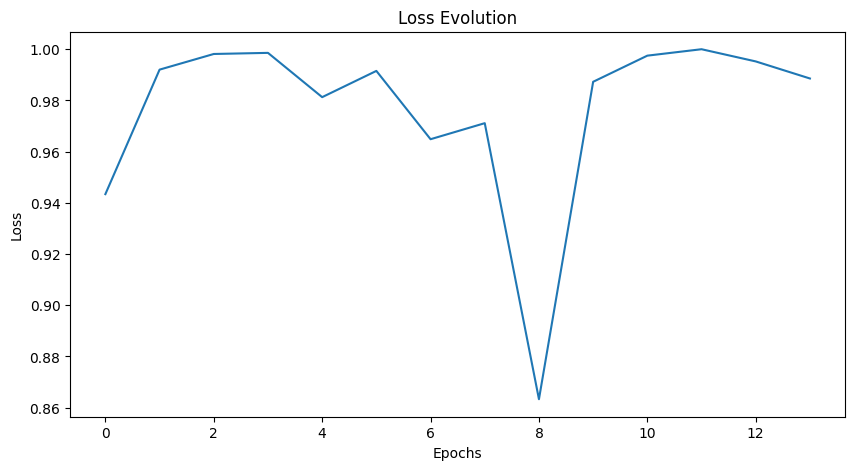

In [18]:

from scipy.ndimage import label
if __name__ == "__main__":
    save_output_folder = "/home/paulagmtz/TFM_PAULA_24/DATA_TFM/outputs_models/multilabel_diceloss/"
    # Realizar la validación
    loss_evolution, average_metric, average_accuracy = validate_model(model, val_dataloader, device,save_output_folder)
    

validation dataloader

MULTILABEL 200 diceCEloss 

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

Average Metric: tensor([943.0676, 944.1576], device='cuda:1')
Average ACCURACY: 9.616151510272175e-05


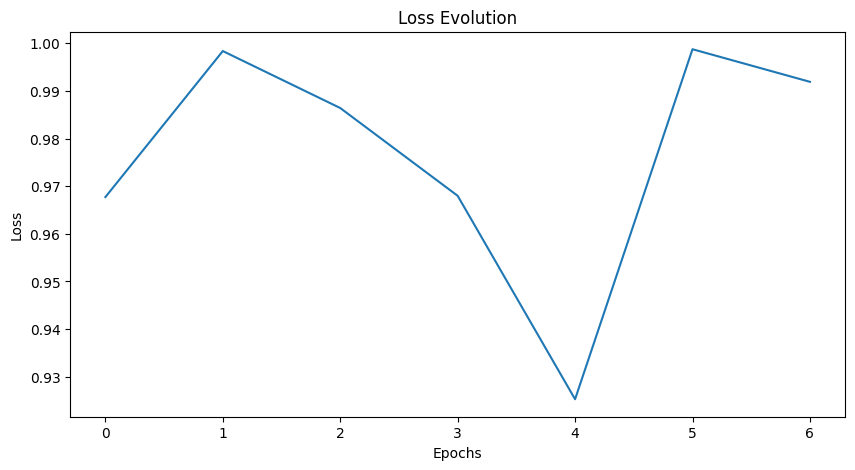

In [14]:

from scipy.ndimage import label
if __name__ == "__main__":
    save_output_folder = "/home/paulagmtz/TFM_PAULA_24/DATA_TFM/outputs_models/multilabel_diceloss/"
    # Realizar la validación
    loss_evolution, average_metric, average_accuracy = validate_model(model, val_dataloader, device)

# POST PROCESSING MULTILABEL 

# EVALUATION UNET ONE LABEL SIGMA 2

In [27]:
# train
root_dir ="/home/paulagmtz/TFM_PAULA_24/DATA_TFM/train_files"
input_dim = (194,148,105)
n_labels= 1
train_dataset = dataset_old.PelvisDataset(root_dir,input_dim, n_labels, transform=None)

train_dataloader = DataLoader(train_dataset, collate_fn=pad_list_data_collate,batch_size =2)

In [28]:
root_dir ="/home/paulagmtz/TFM_PAULA_24/DATA_TFM/val_files"
input_dim =(194,148,105)
n_labels= 1
val_dataset = dataset_old.PelvisDataset(root_dir,input_dim, n_labels, transform=None)

val_dataloader = DataLoader(val_dataset, batch_size =2)

In [29]:
#%%
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from UNETR import UNETR  
from dataset import PelvisDataset  
import monai
from monai.losses import DiceLoss 
from monai.metrics import MSEMetric 
from torchmetrics import Accuracy
from monai.metrics import DiceMetric

# Función para cargar el modelo y realizar la validación


def euclidean_distance(predictions, targets):
    # print(predictions)
    # print(targets)
    # print(predictions.shape)
    # print(targets.shape)
    
    # Aplanar los tensores
    predictions_flat = predictions.view(2, -1)
    targets_flat = targets.view(2, -1)
    dist = torch.norm(targets_flat-predictions_flat,dim=1)
    return dist
def validate_model_one_label(model, val_dataloader, device):
    model.eval()  # Modo de evaluación

    # Definir la función de pérdida
    loss_function = DiceLoss(sigmoid=True, squared_pred=True)

    # Variables para almacenar la evolución de la métrica
    metric_history = []
    loss_evolution = []
    
    accuracy_evolution = []

    with torch.no_grad():
        for batch in val_dataloader:
            inputs, targets = batch[0].to(device), batch[1].to(device)
            print(inputs.shape)
            # Realizar predicciones
            outputs = model(inputs)
            out =  nn.functional.sigmoid(outputs)

            # Calcular la pérdida
            loss = loss_function(outputs, targets)
            
            accuracy = Accuracy(task="binary").to(device)
            acc = accuracy(out, targets)
            # dice = DiceMetric(outputs, targets)

            # caluclar la distancia euclidea
            dist = euclidean_distance(out, targets)
            # Guardar la métrica
            loss_evolution.append(loss.item())
            metric_history.append(dist)
            accuracy_evolution.append(acc)

            # Mostrar imágenes de inputs, targets y outputs
            plot_results(inputs, targets, out)

    # Calcular la métrica promedio
    average_metric = sum(metric_history) / len(metric_history)
    average_accuracy = sum(accuracy_evolution)/(len(accuracy_evolution))
    print(f'Average Metric: {average_metric}')
    print(f'Average ACCURACY: {average_accuracy}')
    # loss_evolution_cpu = [tensor.cpu() for tensor in loss_evolution]  # Mover cada tensor a la CPU
    # loss_evolution_numpy = [tensor.detach().numpy() for tensor in loss_evolution]  # Convertir cada tensor a un array de NumPy
    # loss_evolution_numpy = [tensor.numpy() for tensor in loss_evolution]
    plot_loss_evolution(loss_evolution)


    # Guardar la evolución de la métrica en un archivo (por ejemplo, un archivo de texto)
    with open("metric_history.txt", "w") as f:
        for metric in metric_history:
            f.write(f"{metric}\n")
    return loss_evolution, average_metric, average_accuracy

# Función para mostrar imágenes de inputs, targets y outputs
def plot_results(inputs, targets, outputs):
    depth_slice = inputs[:, :, :, :, :]
    depth_slice_target = targets[:, :, :, :, :]
    depth_slice_outputs = outputs[:, :, :, :, :]

    def plot_image(i):
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))

        image_array = depth_slice[0, :, i, :, :].cpu().detach().numpy()
        image_array_target = depth_slice_target[0, :, i, :, :].cpu().detach().numpy()
        image_array_outputs = depth_slice_outputs[0, :, i, :, :].cpu().detach().numpy()

        axes[0].imshow(image_array[0, :, :], cmap="gray")
        axes[0].set_title("inputs")
        axes[0].axis('off')

        axes[1].imshow(image_array_target[0, :, :], cmap="gray")
        axes[1].set_title("target")
        axes[1].axis('off')

        axes[2].imshow(image_array_outputs[0, :, :], cmap="gray")
        axes[2].set_title("output")
        axes[2].axis('off')

        plt.show()

    widgets.interact(plot_image, i=widgets.IntSlider(min=0, max=depth_slice.shape[2]-1, step=1, value=22))



## 1. UNET 200 epochs dice with surface points

In [30]:
# from monai.model import Unet
# # Create an instance of your model (ensure that it has the same architecture)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=3 ,
    in_channels=1,
    out_channels=1,
    channels=(64,128,256,512), 
    strides=(2,2,2),
    # num_res_units=2,
    # norm=Norm.BATCH,    
).to(device)
# Load the saved model parameters
model.load_state_dict(torch.load("/home/paulagmtz/TFM_PAULA_24/DATA_TFM/models_result/UNET_model_200_surface_points.pth"))

# Set the model to evaluation mode
model.eval()


UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): 

In [31]:

if __name__ == "__main__":
    # Cargar el modelo
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    # model = UNETR(in_channels=1, out_channels=1, img_size=(112, 160, 208), feature_size=32, norm_name='batch')
    # model.to(device)
    # model.load_state_dict(torch.load("/home/paulagmtz/TFM_PAULA_24/MONAI-UNET/UNETR.pth"))


    # Realizar la validación
    loss_evolution, average_metric, average_accuracy = validate_model_one_label(model, val_dataloader, device)

torch.Size([2, 1, 112, 160, 208])


OutOfMemoryError: CUDA out of memory. Tried to allocate 228.00 MiB (GPU 1; 23.70 GiB total capacity; 9.83 GiB already allocated; 91.81 MiB free; 10.04 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## 2. UNET 200 epochs dice CE loss with surface points

In [21]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = UNet(spatial_dims=3 ,in_channels=1,out_channels=1,channels=(64,128,256,512), strides=(2,2,2),).to(device)
# Load the saved model parameters
model.load_state_dict(torch.load("/home/paulagmtz/TFM_PAULA_24/DATA_TFM/models_result/UNET_model_SIGMA2_200_sp_diceCEloss.pth"))

# Set the model to evaluation mode
model.eval()

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): 

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

Average Metric: tensor([11.7106,  9.9990], device='cuda:1')
Average ACCURACY: 0.9999591708183289


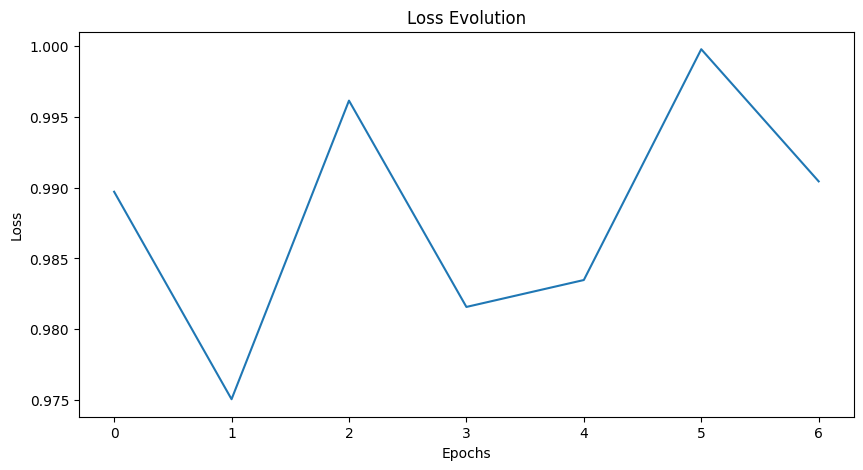

In [22]:

if __name__ == "__main__":
    # Cargar el modelo
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    # Realizar la validación
    loss_evolution, average_metric, average_accuracy = validate_model_one_label(model, val_dataloader, device)

## 3. UNET 200 epochs DICE FOCALL loss 

In [23]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = UNet(spatial_dims=3 ,in_channels=1,out_channels=1,channels=(64,128,256,512), strides=(2,2,2),).to(device)
# Load the saved model parameters
model.load_state_dict(torch.load("/home/paulagmtz/TFM_PAULA_24/DATA_TFM/models_result/UNET_model_SIGMA2_200_sp_dicefocalllosss.pth"))

# Set the model to evaluation mode
# model.eval()

<All keys matched successfully>

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=22, description='i', max=111), Output()), _dom_classes=('widget-interact…

Average Metric: tensor([11.9350, 10.1460], device='cuda:1')
Average ACCURACY: 0.9999605417251587


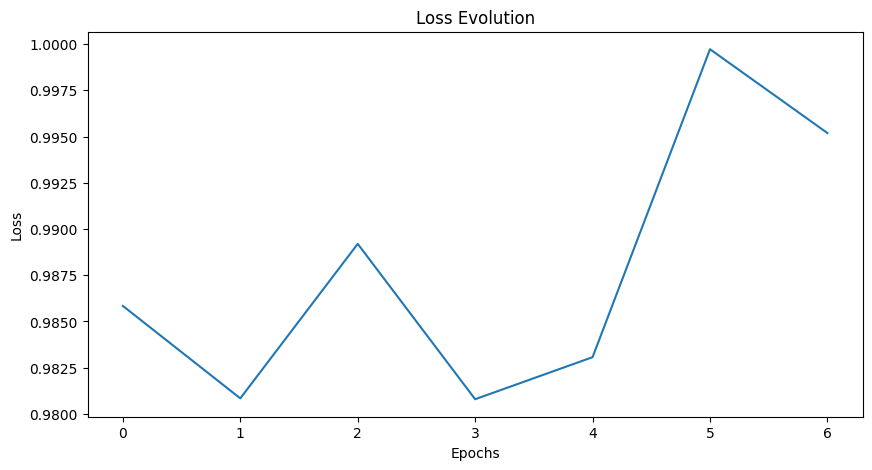

In [24]:

if __name__ == "__main__":
    # Cargar el modelo
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    # Realizar la validación
    loss_evolution, average_metric, average_accuracy = validate_model_one_label(model, val_dataloader, device)

# EVALUATION ATTENTION UNET ONE LABEL SIGMA 2

In [25]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


model = AttentionUnet(
    spatial_dims=3 ,
    in_channels=1,
    out_channels=1,
    channels=(64,128), 
    strides=(2,2),
        
).to(device)
# Load the saved model parameters
model.load_state_dict(torch.load("/home/paulagmtz/TFM_PAULA_24/DATA_TFM/models_result/ATTENTION_UNET_model_SIGMA2_300_sp_dicefocalllosss.pth"))

# Set the model to evaluation mode
# model.eval()

<All keys matched successfully>

In [26]:

if __name__ == "__main__":
    # Cargar el modelo
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    # Realizar la validación
    loss_evolution, average_metric, average_accuracy = validate_model_one_label(model, val_dataloader, device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.78 GiB (GPU 1; 23.70 GiB total capacity; 9.19 GiB already allocated; 575.81 MiB free; 9.57 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF